In [2]:
import PostProcessing as PP
import numpy as np
from CollisionApprox import Collision_approx as ca
from nu_e_coll import nu_e_collisions as ve
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import support_functions as sf

dtda_part2 = 2*np.pi/3
me = .511 
mPL = 1.124*10**22 

In [ ]:
n_b, n_p = PP.pp(300,1.28e-5)

N effective is 2.99
The dilution factor is 1.62


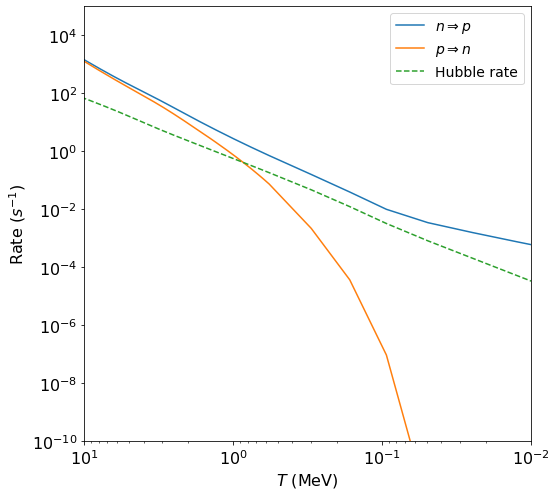

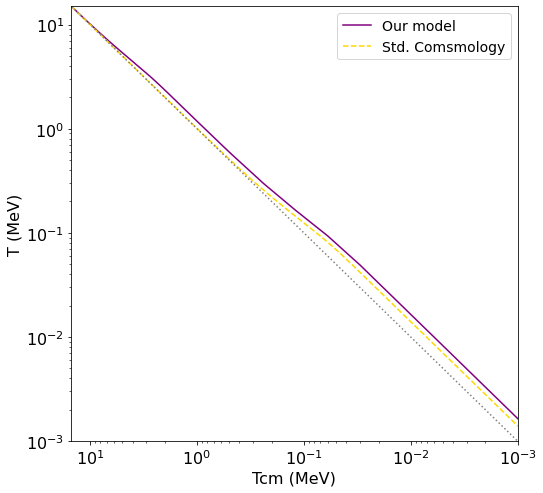

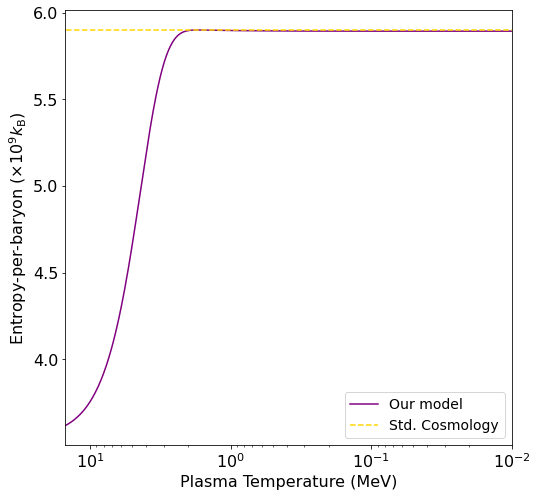

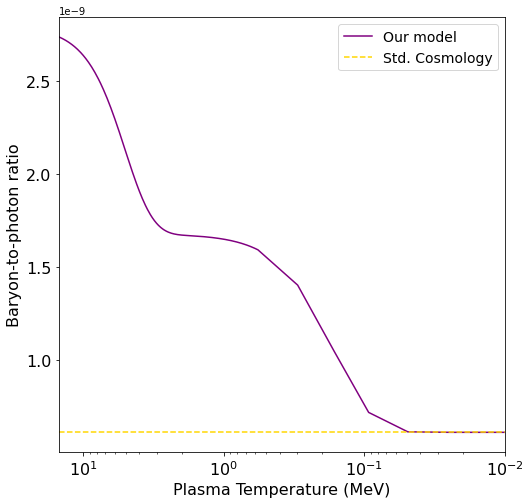

The initial baryon-to-photon ratio is  2.7370161119368913e-09


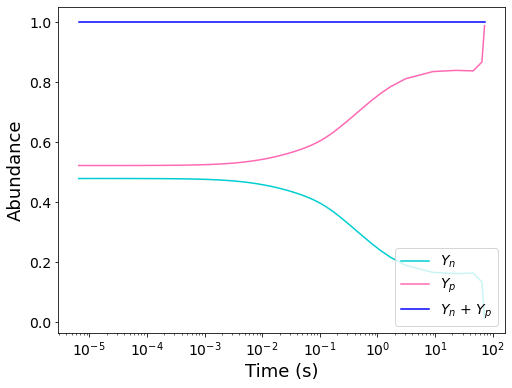

In [3]:
n_b, n_p = PP.pp(300,7e-5)

In [ ]:
PP.inspect_graphs(300,1.28e-5)

In [ ]:
PP.inspect_graphs(300,7e-5)

In [ ]:
PP.make_graphs(300,1.28e-5)

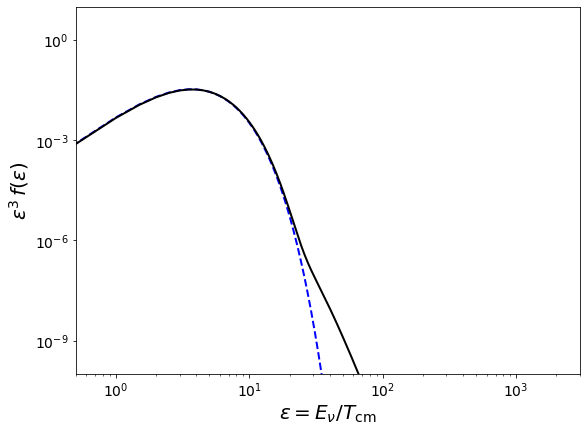

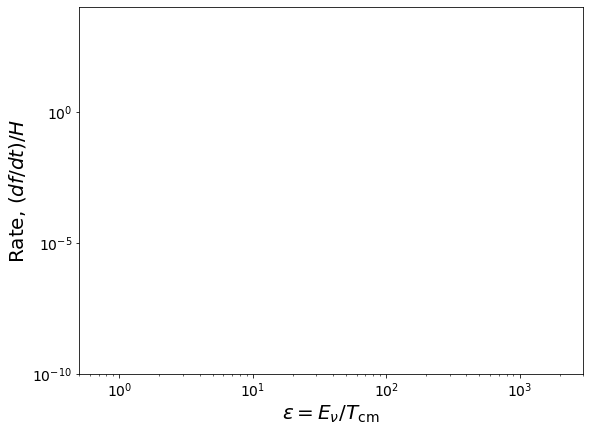

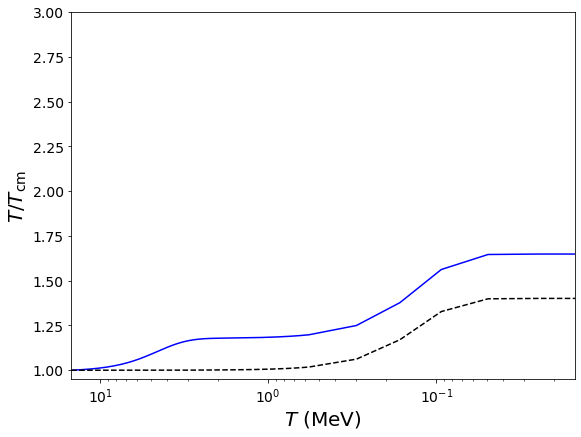

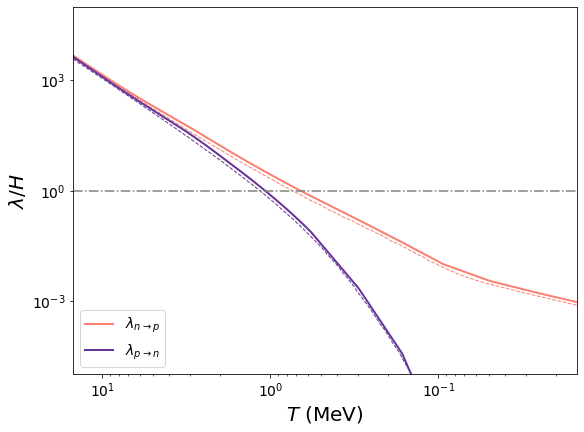

In [4]:
PP.make_graphs(300,7e-5)

In [ ]:
PP.make_movies(300,1.28e-5)

In [ ]:
PP.make_movies(300,7e-5)

In [ ]:
dilresults = np.load("/Users/hannahrasmussen/Work/Most_recent_code/300data/300data/300data_final.npz")
lifetime_array = dilresults['lifetime']
dil_array = dilresults['Dilution_Factor']
N_eff_array = dilresults['N_eff']

plt.figure(figsize=(8,6))
plt.semilogx(lifetime_array,dil_array,'o',color='k')
plt.xlabel("$\\tau(s)$",fontsize=16)
plt.ylabel("Dilution Factor",fontsize=16)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
#plt.savefig("dilution.pdf")

plt.figure(figsize=(8,6))
plt.semilogx(lifetime_array,N_eff_array,'o',color='k')
plt.xlabel("$\\tau(s)$",fontsize=16)
plt.ylabel("$N_{\\rm eff}$",fontsize=16)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
#plt.savefig("neff.pdf")

In [5]:
def cs(x,y):
    n = len(x)-1 #THE NUMBER OF INTERVALS
    h = x[1:]-x[:-1] #interval widths, not necessarily constant, has length n (one less than x and y)
    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    d = np.zeros(n) 
    sig = np.zeros(n+1) #the right side of the augmented matrix
    tri = np.zeros((n-1,n)) #triagonal matrix to be solved? not sure why it's n-1 by n
    output = np.zeros((n,5))
    
    for i in range(n-1):
        tri[i][i] = 2*(h[i] + h[i+1])
    for i in range(n-2):
        tri[i][i+1] = h[i+1]
        tri[i+1][i] = h[i+1]
    for i in range(1,n):
        tri[i-1][n-1] = 6*(y[i+1]-y[i])/h[i] - 6*(y[i]-y[i-1])/h[i-1]
    
    for i in range(n-2):
        for j in range(i+1,n-1):
            term = tri[j][i]/tri[i][i]
            for k in range(n):
                tri[j][k] = tri[j][k] - term*tri[i][k]          
    
    for i in range(n-1):
        ii = n-2 - i
        sig[ii+1] = tri[ii][n-1]
        for j in range(ii+1,n-1):
            sig[ii+1] = sig[ii+1] - tri[ii][j]*sig[j+1]
        sig[ii+1] = sig[ii+1]/tri[ii][ii]
    
    for i in range(n): #again, the format is ai(x-xi)^3 + bi(x-xi)^2 + ci(x-xi) +di
        a[i] = (sig[i+1]-sig[i])/(6*h[i]);
        b[i] = sig[i]/2
        c[i] = (y[i+1]-y[i])/h[i] - h[i]*(2*sig[i]+sig[i+1])/6;
        d[i] = y[i]
    
    return x[:-1], a, b, c, d

In [6]:
def make_splines(ms,mix):
    ############ Uploading data ############
    results = np.load("/Users/hannahrasmussen/Work/Most_recent_code/{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/movie_arrays.npz".format(ms,mix,ms,mix), allow_pickle=True)
    scale_arr = results['a']
    T_arr = results['T']
    t_arr = results['t']
    e_mat = results['e']
    f_mat = results['f']
    n2p = results['np']
    p2n = results['pn']
    print("Temp after which we just return 0 for dQdt and ns: ",T_arr[239]) #the temp after which dQdt plummets to 0

    ############ Shifting Tcm so T=Tcm at Ti (T_BBN) for alterBBN ############
    Tcm_arr = 1/scale_arr
    T_BBN = T_arr[0]      #the temp we're going to set for the initial temp in alterBBN, T_BBN = 14.87365053664758 for mix=7e-5
    Tcm_BBN = Tcm_arr[0]  #the comoving temp in our data that corresponds to T_BBN
    shift = T_BBN/Tcm_BBN   #the factor we're multiplying Tcm_arr by to get the x axis we'll use for cubic splining
    Tcm_adj = shift*Tcm_arr #this makes it so the initial temp in alterBBN is equivalent to the initial Tcm in alterBBN

    ############ Creating and saving rho_nu cubic spline arrays ############
    rho_nu = np.zeros(len(scale_arr))
    for i in range(len(scale_arr)):
        rho_nu[i] = 6*(Tcm_arr[i]**4)/(2*np.pi**2)*sf.trapezoid(f_mat[i]*e_mat[i]**3,e_mat[i])

    Tcm_rhonu, a_rhonu, b_rhonu, c_rhonu, d_rhonu = cs(Tcm_adj,rho_nu)
    Tcm_save = pd.DataFrame(Tcm_rhonu)
    a_save = pd.DataFrame(a_rhonu)
    b_save = pd.DataFrame(b_rhonu)
    c_save = pd.DataFrame(c_rhonu)
    d_save = pd.DataFrame(d_rhonu)
    Tcm_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_Tcm_rhonu.csv".format(ms,mix,ms,mix,ms,mix))
    a_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_a_rhonu.csv".format(ms,mix,ms,mix,ms,mix))
    b_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_b_rhonu.csv".format(ms,mix,ms,mix,ms,mix))
    c_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_c_rhonu.csv".format(ms,mix,ms,mix,ms,mix))
    d_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_d_rhonu.csv".format(ms,mix,ms,mix,ms,mix))

    ############ Creating and saving dQdt cubic spline arrays ############
    dadt = np.zeros(len(scale_arr))
    dQdt = np.zeros(len(scale_arr)-1) #going to correspond to scale_arr[1:]

    for i in range(len(dadt)):
        a = scale_arr[i]
        t = t_arr[i]
        T = T_arr[i]
        dtda_part1 = mPL/(2*a)
        dtda_part3 = (T**4*np.pi**2)/15
        dtda_part4 = 2*T**4*sf.calculate_integral(sf.I1,me/T)/np.pi**2
        dtda_part6 = ms*sf.ns(1/a,t,ms,mix)
        dtda_part7 = ((1/a)**4/(2*np.pi**2))*sf.trapezoid(f_mat[i]*e_mat[i]**3,e_mat[i])
        dtda = dtda_part1/(dtda_part2*(dtda_part3+dtda_part4+dtda_part6+dtda_part7))**.5
        dadt[i] = 1/dtda

    for i in range(1,len(scale_arr)):
        a = scale_arr[i]
        t = t_arr[i]
        df = sf.trapezoid(f_mat[i]*e_mat[i]**3,e_mat[i]) - sf.trapezoid(f_mat[i]*e_mat[i]**3,e_mat[i])
        dQda_part1 = ms*sf.ns(1/a,t,ms,mix)*a**3/sf.ts(ms,mix)
        dQda_part2 = dadt[i]*a*df/(2*np.pi**2)
        dQdt[i-1] = (dQda_part1 - dQda_part2)/(a**3)
    
    T_dQdt, a_dQdt, b_dQdt, c_dQdt, d_dQdt = cs(T_arr[1:],dQdt) #does this T_arr need to be shifted?
    T_save = pd.DataFrame(T_dQdt)
    a_save = pd.DataFrame(a_dQdt)
    b_save = pd.DataFrame(b_dQdt)
    c_save = pd.DataFrame(c_dQdt)
    d_save = pd.DataFrame(d_dQdt)
    T_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_T_dQdt.csv".format(ms,mix,ms,mix,ms,mix))
    a_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_a_dQdt.csv".format(ms,mix,ms,mix,ms,mix))
    b_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_b_dQdt.csv".format(ms,mix,ms,mix,ms,mix))
    c_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_c_dQdt.csv".format(ms,mix,ms,mix,ms,mix))
    d_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_d_dQdt.csv".format(ms,mix,ms,mix,ms,mix)) 
    
    ############ Creating and saving np cubic spline arrays ############
    np_arr = n2p
    T_np, a_np, b_np, c_np, d_np = cs(T_arr,np_arr) #does this T_arr need to be shifted? and is this the right independent variable?
    T_save = pd.DataFrame(T_np)
    a_save = pd.DataFrame(a_np)
    b_save = pd.DataFrame(b_np)
    c_save = pd.DataFrame(c_np)
    d_save = pd.DataFrame(d_np)
    T_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_T_np.csv".format(ms,mix,ms,mix,ms,mix))
    a_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_a_np.csv".format(ms,mix,ms,mix,ms,mix))
    b_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_b_np.csv".format(ms,mix,ms,mix,ms,mix))
    c_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_c_np.csv".format(ms,mix,ms,mix,ms,mix))
    d_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_d_np.csv".format(ms,mix,ms,mix,ms,mix))
    
    ############ Creating and saving pn cubic spline arrays ############
    pn_arr = p2n
    T_pn, a_pn, b_pn, c_pn, d_pn = cs(T_arr,pn_arr) #does this T_arr need to be shifted? and is this the right independent variable?
    T_save = pd.DataFrame(T_pn)
    a_save = pd.DataFrame(a_pn)
    b_save = pd.DataFrame(b_pn)
    c_save = pd.DataFrame(c_pn)
    d_save = pd.DataFrame(d_pn)
    T_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_T_pn.csv".format(ms,mix,ms,mix,ms,mix))
    a_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_a_pn.csv".format(ms,mix,ms,mix,ms,mix))
    b_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_b_pn.csv".format(ms,mix,ms,mix,ms,mix))
    c_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_c_pn.csv".format(ms,mix,ms,mix,ms,mix))
    d_save.to_csv("../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/mass_{}_mix_{:.4}_d_pn.csv".format(ms,mix,ms,mix,ms,mix))
    
    ############ Printing out initial vs number density to put into alterBBN ############
    ns_arr = np.zeros(len(T_arr))
    ns_arr = sf.ns(Tcm_arr,t_arr,ms,mix)
    print("The number density of sterile neutrinos at ",T_arr[0]," is ",ns_arr[0]," MeV^3.")
    
    ############ Graphically comparing rho_nu to rho_nu approximated by cubic spline arrays ############
    Tcm_graph = np.logspace(1.1,-3.1,100)
    rho_nu_graph = np.zeros(len(Tcm_graph))
    for i in range(len(Tcm_graph)):
        index = 0
        x = Tcm_graph[i]
        for j in range(len(Tcm_rhonu)): #want to find the index we'll be using to find y
            if (x<Tcm_rhonu[j]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
                index = j
        rho_nu_graph[i] = a_rhonu[index]*(x-Tcm_rhonu[index])**3 + b_rhonu[index]*(x-Tcm_rhonu[index])**2 + c_rhonu[index]*(x-Tcm_rhonu[index]) + d_rhonu[index]
    
    plt.figure(figsize=(8,8))
    plt.loglog(Tcm_adj,rho_nu,color="blue")
    plt.loglog(Tcm_graph,rho_nu_graph,color="red")
    plt.xlim(15,0.0001)
    plt.ylim(1e-12,1e5)
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.xlabel("$T_{\\rm cm}$", fontsize=20)
    plt.ylabel("$\\rho_{\\nu}$", fontsize=20)
    plt.show()
    
    ########### Graphically comparing dQdt to dQdt approximated by cubic spline arrays ############
    T_graph = np.logspace(1.1,-0.8,10000)
    dQdt_graph = np.zeros(len(T_graph))
    for i in range(len(T_graph)):
        index = 0
        x = T_graph[i]
        if (T_graph[i]<0.6635):
            dQdt_graph[i] = 0
        else:
            for j in range(len(T_dQdt)): #want to find the index we'll be using to find y
                if (x<T_dQdt[j]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
                    index = j
            dQdt_graph[i] = a_dQdt[index]*(x-T_dQdt[index])**3 + b_dQdt[index]*(x-T_dQdt[index])**2 + c_dQdt[index]*(x-T_dQdt[index]) + d_dQdt[index]

    plt.figure(figsize=(8,8))
    plt.loglog(T_arr[1:],dQdt/T_arr[1:],color="blue")
    plt.loglog(T_graph,dQdt_graph/T_graph,color="red")
    plt.xlim(15,0.6)
    plt.ylim(1e-50,1e-10)
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.xlabel("$T$", fontsize=20)
    plt.ylabel("$(dQ/dt)/T$", fontsize=20)
    plt.show()
    
    ############# Graphically comparing np to np approximated by cubic spline arrays ############
    T_graph = np.logspace(1.1,-3.1,10000)
    np_graph = np.zeros(len(T_graph))
    for i in range(len(T_graph)):
        index = 0
        x = T_graph[i]
        for j in range(len(T_np)): #want to find the index we'll be using to find y
            if (x<T_np[j]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
                index = j
        np_graph[i] = a_np[index]*(x-T_np[index])**3 + b_np[index]*(x-T_np[index])**2 + c_np[index]*(x-T_np[index]) + d_np[index]
    
    plt.figure(figsize=(8,8))
    plt.loglog(T_arr,np_arr,color="blue")
    plt.loglog(T_graph,np_graph,color="red")
    plt.xlim(15,0.0001)
    #plt.ylim(10e-60,10e-50)
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.xlabel("$T$", fontsize=20)
    plt.ylabel("$n \\to p$", fontsize=20)
    plt.show()
    
    ############# Graphically comparing pn to pn approximated by cubic spline arrays ############
    T_graph = np.logspace(1.1,-3.1,10000)
    pn_graph = np.zeros(len(T_graph))
    for i in range(len(T_graph)):
        index = 0
        x = T_graph[i]
        if (T_graph[i]<0.6635):
            pn_graph[i] = 0
        else:
            for j in range(len(T_pn)): #want to find the index we'll be using to find y
                if (x<T_pn[j]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
                    index = j
            pn_graph[i] = a_pn[index]*(x-T_pn[index])**3 + b_pn[index]*(x-T_pn[index])**2 + c_pn[index]*(x-T_pn[index]) + d_pn[index]
    
    plt.figure(figsize=(8,8))
    plt.loglog(T_arr,pn_arr,color="blue")
    plt.loglog(T_graph,pn_graph,color="red")
    plt.xlim(15,0.0001)
    #plt.ylim(10e-60,10e-50)
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.xlabel("$T$", fontsize=20)
    plt.ylabel("$p \\to n$", fontsize=20)
    plt.show()

In [7]:
def make_eq_splines():
    ############ Uploading data ############
    scale_arr = np.load("/Users/hannahrasmussen/Work/Most_recent_code/0-0-FullTestNew/0-0-FullTestNew/Hannah_a.npy")
    T_arr = np.load("/Users/hannahrasmussen/Work/Most_recent_code/0-0-FullTestNew/0-0-FullTestNew/Hannah_T.npy")
    Tcm_arr = 1/scale_arr
    results = np.load("/Users/hannahrasmussen/Work/Most_recent_code/{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/movie_arrays.npz".format(300,7e-5,300,7e-5), allow_pickle=True)
    #Tnp = results['T']
    n2p = results['np_SM']
    p2n = results['pn_SM']
    
    ############ Creating and saving rho_nu cubic spline arrays ############
    rho_nu = np.zeros(len(scale_arr))
    for i in range(len(scale_arr)):
        rho_nu[i] = (7*np.pi**2/40)*(Tcm_arr[i])**4

    Tcm_rhonu, a_rhonu, b_rhonu, c_rhonu, d_rhonu = cs(Tcm_arr,rho_nu)
    Tcm_save = pd.DataFrame(Tcm_rhonu)
    a_save = pd.DataFrame(a_rhonu)
    b_save = pd.DataFrame(b_rhonu)
    c_save = pd.DataFrame(c_rhonu)
    d_save = pd.DataFrame(d_rhonu)
    Tcm_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_Tcm_rhonu.csv")
    a_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_a_rhonu.csv")
    b_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_b_rhonu.csv")
    c_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_c_rhonu.csv")
    d_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_d_rhonu.csv")

    ############ Creating and saving dQdt cubic spline arrays ############
    dQdt = np.zeros(len(T_arr))
    for i in range(len(T_arr)):
        dQdt[i] = 0 #no heat added because no sterile neutrinos!

    T_dQdt, a_dQdt, b_dQdt, c_dQdt, d_dQdt = cs(T_arr,dQdt)
    T_save = pd.DataFrame(T_dQdt)
    a_save = pd.DataFrame(a_dQdt)
    b_save = pd.DataFrame(b_dQdt)
    c_save = pd.DataFrame(c_dQdt)
    d_save = pd.DataFrame(d_dQdt)
    T_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_T_dQdt.csv")
    a_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_a_dQdt.csv")
    b_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_b_dQdt.csv")
    c_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_c_dQdt.csv")
    d_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_d_dQdt.csv")
    
    ############ Creating and saving np cubic spline arrays ############
    np_arr = n2p 
    T_np, a_np, b_np, c_np, d_np = cs(T_arr,np_arr) #T and np arrays need to have the same length here
    T_save = pd.DataFrame(T_np)
    a_save = pd.DataFrame(a_np)
    b_save = pd.DataFrame(b_np)
    c_save = pd.DataFrame(c_np)
    d_save = pd.DataFrame(d_np)
    T_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_T_np.csv")
    a_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_a_np.csv")
    b_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_b_np.csv")
    c_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_c_np.csv")
    d_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_d_np.csv")
    
    ############ Creating and saving pn cubic spline arrays ############
    pn_arr = p2n 
    T_pn, a_pn, b_pn, c_pn, d_pn = cs(T_arr,pn_arr) #T and np arrays need to have the same length here
    T_save = pd.DataFrame(T_pn)
    a_save = pd.DataFrame(a_pn)
    b_save = pd.DataFrame(b_pn)
    c_save = pd.DataFrame(c_pn)
    d_save = pd.DataFrame(d_pn)
    T_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_T_pn.csv")
    a_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_a_pn.csv")
    b_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_b_pn.csv")
    c_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_c_pn.csv")
    d_save.to_csv("../../0-0-FullTestNew/0-0-FullTestNew/mass_0_mix_0_d_pn.csv")
    
    ############ Graphically comparing rho_nu to rho_nu approximated by cubic spline arrays ############
    Tcm_graph = np.logspace(1.1,-3.1,100)
    rho_nu_graph = np.zeros(len(Tcm_graph))
    for i in range(len(Tcm_graph)):
        index = 0
        x = Tcm_graph[i]
        for j in range(len(Tcm_rhonu)): #want to find the index we'll be using to find y
            if (x<Tcm_rhonu[j]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
                index = j
        rho_nu_graph[i] = a_rhonu[index]*(x-Tcm_rhonu[index])**3 + b_rhonu[index]*(x-Tcm_rhonu[index])**2 + c_rhonu[index]*(x-Tcm_rhonu[index]) + d_rhonu[index]
    
    plt.figure(figsize=(8,8))
    plt.loglog(Tcm_arr,rho_nu,color="blue")
    plt.loglog(Tcm_graph,rho_nu_graph,color="red")
    plt.xlim(15,0.0001)
    plt.ylim(1e-12,1e5)
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.xlabel("$T_{\\rm cm}$", fontsize=20)
    plt.ylabel("$\\rho_{\\nu}$", fontsize=20)
    plt.show()
    
    ########### Graphically comparing dQdt to dQdt approximated by cubic spline arrays ############
    T_graph = np.logspace(1.1,-3.1,10000)
    dQdt_graph = np.zeros(len(T_graph))
    for i in range(len(T_graph)):
        index = 0
        x = T_graph[i]
        for j in range(len(T_dQdt)): #want to find the index we'll be using to find y
            if (x<T_dQdt[j]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
                index = j
        dQdt_graph[i] = a_dQdt[index]*(x-T_dQdt[index])**3 + b_dQdt[index]*(x-T_dQdt[index])**2 + c_dQdt[index]*(x-T_dQdt[index]) + d_dQdt[index]

    plt.figure(figsize=(8,8))
    plt.plot(T_arr,dQdt,color="blue")
    plt.plot(T_graph,dQdt_graph,color="red")
    plt.xlim(15,0.1)
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.xlabel("$T$", fontsize=20)
    plt.ylabel("$dQ/dt$", fontsize=20)
    plt.show()
    
    ############# Graphically comparing np to np approximated by cubic spline arrays ############
    np_graph = np.zeros(len(T_graph))
    for i in range(len(T_graph)):
        index = 0
        x = T_graph[i]
        for j in range(len(T_np)): #want to find the index we'll be using to find y
            if (x<T_np[j]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
                index = j
        np_graph[i] = a_np[index]*(x-T_np[index])**3 + b_np[index]*(x-T_np[index])**2 + c_np[index]*(x-T_np[index]) + d_np[index]
    
    plt.figure(figsize=(8,8))
    plt.loglog(T_arr,np_arr,color="blue")
    plt.loglog(T_graph,np_graph,color="red")
    plt.xlim(20,0.0001)
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.xlabel("$T$", fontsize=20)
    plt.ylabel("$n \\to p$", fontsize=20)
    plt.show()
    
    ############# Graphically comparing pn to pn approximated by cubic spline arrays ############
    pn_graph = np.zeros(len(T_graph))
    for i in range(len(T_graph)):
        index = 0
        x = T_graph[i]
        if (T_graph[i]<0.07):
            pn_graph[i] = 0
        else:
            for j in range(len(T_pn)): #want to find the index we'll be using to find y
                if (x<T_pn[j]): #if x is going down, not up, as i increases, this will need to be changed to if (x<output[i,0]):
                    index = j
            pn_graph[i] = a_pn[index]*(x-T_pn[index])**3 + b_pn[index]*(x-T_pn[index])**2 + c_pn[index]*(x-T_pn[index]) + d_pn[index]
    
    plt.figure(figsize=(8,8))
    plt.loglog(T_arr,pn_arr,color="blue")
    plt.loglog(T_graph,pn_graph,color="red")
    plt.xlim(20,0.0001)
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.xlabel("$T$", fontsize=20)
    plt.ylabel("$p \\to n$", fontsize=20)
    plt.show()

Temp after which we just return 0 for dQdt and ns:  0.6634974110670931
The number density of sterile neutrinos at  14.87365053664758  is  104.56255360706342  MeV^3.


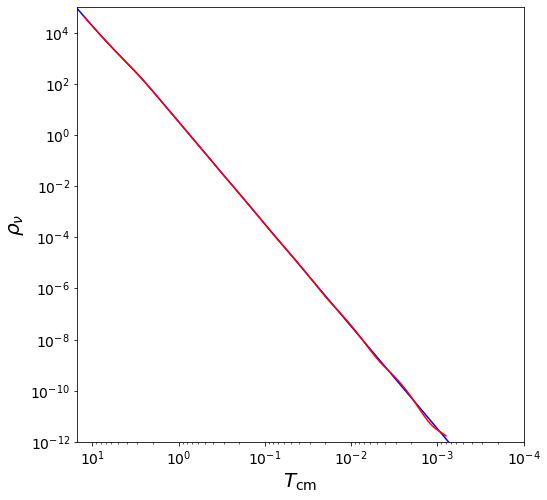

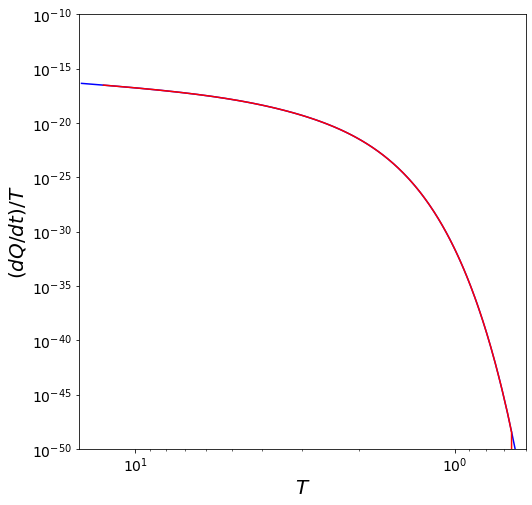

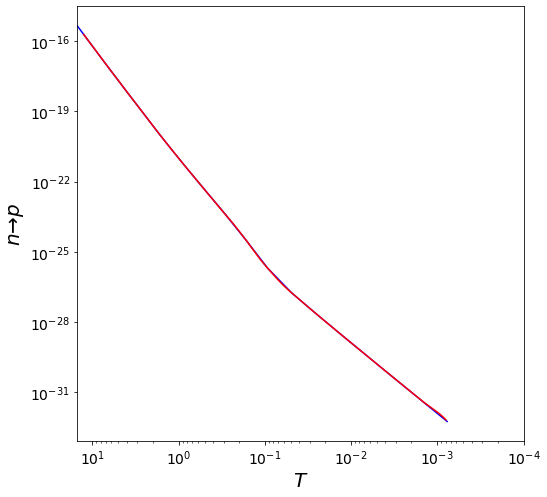

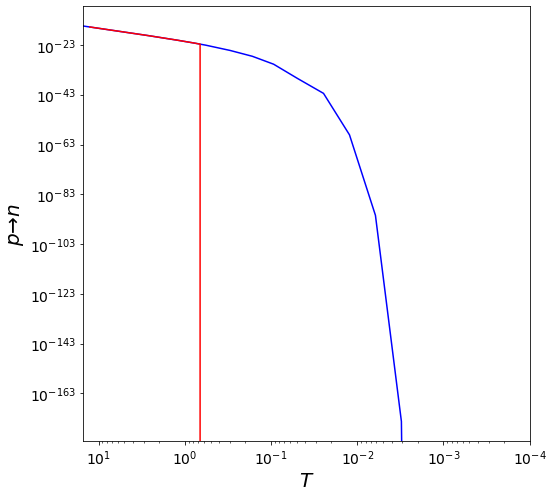

In [8]:
make_splines(300,7e-5)

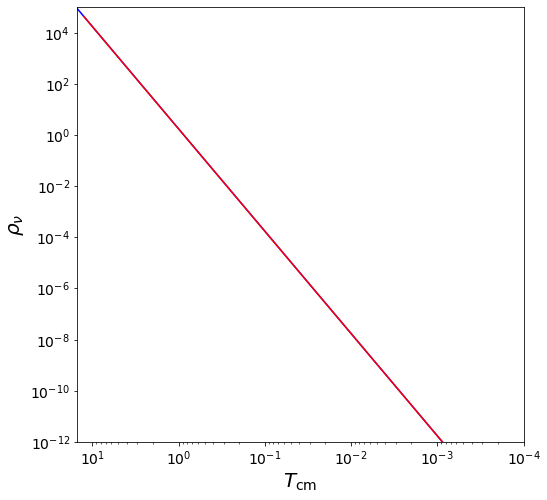

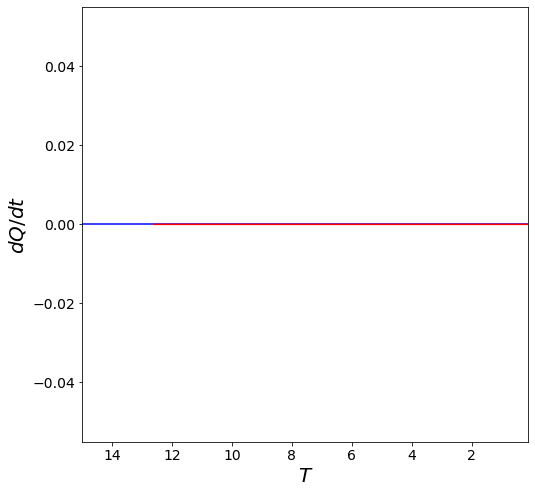

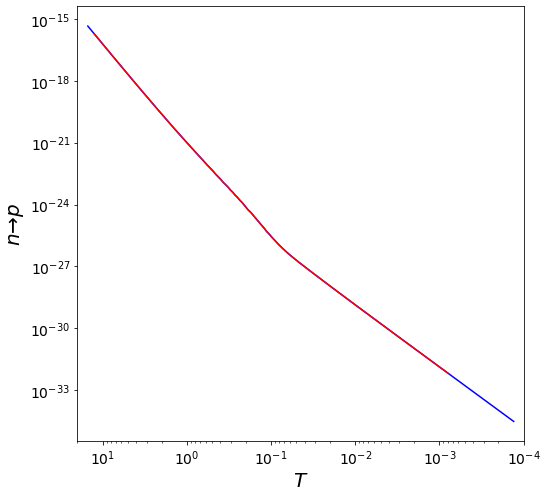

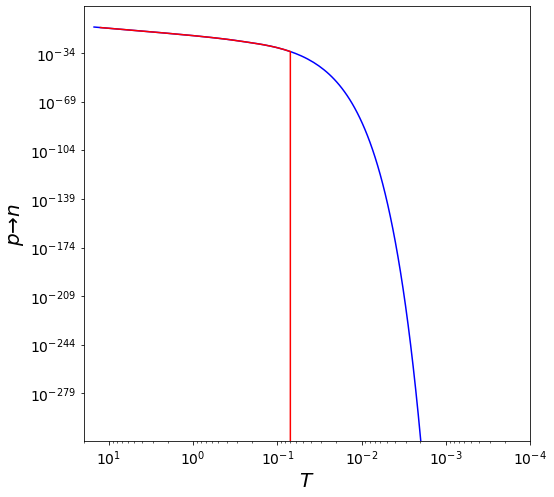

In [9]:
make_eq_splines()

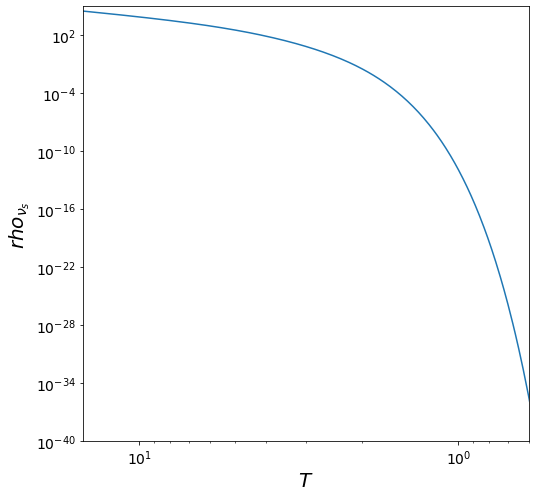

In [10]:
#make graph of rho_vs over T to compare to C code

results = np.load("/Users/hannahrasmussen/Work/Most_recent_code/{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew/movie_arrays.npz".format(300,7e-5,300,7e-5), allow_pickle=True)
a_arr = results['a']
T_arr = results['T']
t_arr = results['t']

rho_vs = np.zeros(len(T_arr))
rho_vs = 300*sf.ns(1/a_arr,t_arr,300,7e-5)

plt.figure(figsize=(8,8))
plt.loglog(T_arr,rho_vs)
plt.xlim(15,0.6)
plt.ylim(1e-40,1e5)
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.xlabel("$T$", fontsize=20)
plt.ylabel("$rho_{\\nu_s}$", fontsize=20)
plt.show()

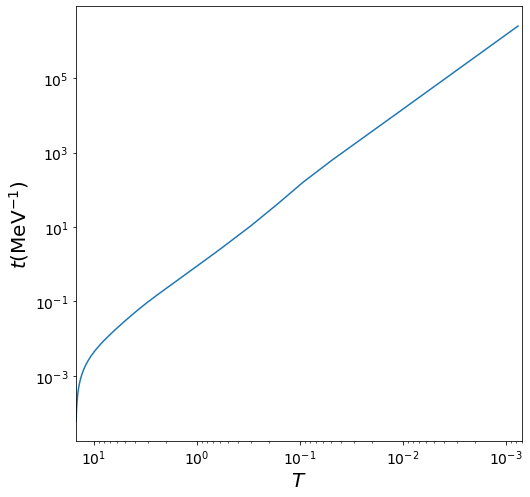

In [26]:
plt.figure(figsize=(8,8))
plt.loglog(T_arr,t_arr/(1.52*10**21))
plt.xlim(15,0.0007)
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.xlabel("$T$", fontsize=20)
plt.ylabel("$t ($MeV$^{-1})$", fontsize=20)
plt.show()